# Libraries

In [396]:
from operator import le
from re import L
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import date

# Source

In [359]:
def get_word_list():
    word_list = []

    # Read from file
    with open("WordList.txt", "r") as file:
        # Read each line and append it to the list
        for line in file:
            word_list.append(line.strip())

    return word_list


In [360]:
def compare_word(a,b, timeframe):
    pytrend = TrendReq()
    pytrend.build_payload(kw_list = [a,b], timeframe = timeframe)
    df_interest = pytrend.interest_over_time()
    df_interest=df_interest.reset_index().drop('isPartial',axis=1)
    df_interest['year_month'] = df_interest['date'].apply(lambda x : (x.year,x.month, x.day))
    df_interest = df_interest.drop('date',axis=1)
    df_interest = df_interest.groupby('year_month').mean().reset_index()
    return df_interest

In [361]:
def get_relative_scores(all_words):
    first_word = all_words[0]
    scores = dict()
    for i in range(1,len(all_words)):
        print("word number {}".format(i))
        scores[i] = compare_word(first_word, all_words[i], timeframe)
    return scores


In [391]:
all_words = get_word_list()
timeframe = 'today 5-y'
scores = get_relative_scores(all_words)

word number 1
word number 2
word number 3
word number 4
word number 5
word number 6
word number 7
word number 8
word number 9
word number 10
word number 11
word number 12
word number 13
word number 14


# Método

- recebe lista de palavras
- comparar palavras dois a dois usando a primeira palavra da lista
- descarta da lista palavras que são incomparáveis com esta palavra "base"
- com as palavras comparáveis, fazer ajuste de escala

In [392]:
scores_adjusted = dict()
first_word = all_words[0]
non_zero_idx = 1
comparable_words = dict()
uncomparable = dict()
for i in range(1,len(all_words)):
    if scores[i][first_word].sum()>0:
        comparable_words[all_words[i]] = scores[i].copy()
    else:
        uncomparable[all_words[i]] =  scores[i].copy()

for k in comparable_words.keys():
    max0 = comparable_words[k][first_word].max()
    max1 =comparable_words[k][k].max()
    if max0!=100:
        comparable_words[k][k] = comparable_words[k][k]/max0 * 100
        comparable_words[k][first_word] = comparable_words[k][first_word]/max0 *100

In [393]:
comparable_list = list(comparable_words.keys())
first_compared = comparable_list[0]
df_compare = comparable_words[first_compared].copy()
for i in range(1,len(comparable_list)):
    w = comparable_list[i]
    df_compare[w] = comparable_words[w][w]
    
df_final = df_compare.melt(['year_month'], 
        var_name="Palavra", 
        value_name="Valor")

df_final = df_final.rename({"year_month" : "Data"},axis=1)
df_final['Data'] = df_final['Data'].apply(lambda x: pd.to_datetime("{}/{}/{}".format(x[0],x[1],x[2])))

In [394]:
#Save csv file
df_final.to_csv("ramoses.csv", encoding = "utf8", sep=";", index=False, decimal = ',')

# Gráfico

In [397]:
today = date.today()


datetime.date(2022, 9, 10)

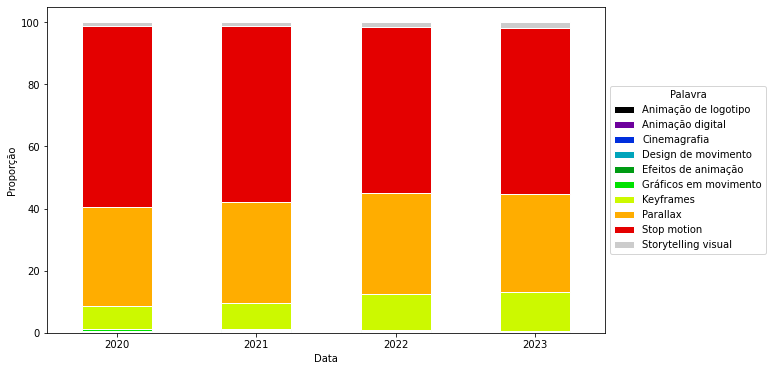

In [436]:
df = df_final.copy()
tipo_data = "year"
numero_meses = 36 #escolher no máximo 5 anos


datamin = pd.to_datetime(today - relativedelta(months = numero_meses))
df = df[df["Data"]>=datamin]

#Remove keywords (set 1==0 to disable)
if 1==0:
    drop_list = ["Animação de logotipo",
    "Stop motion",
     "Parallax",
                 "Keyframes",
                 "Storytelling visual"
    ]
    for c in drop_list:  
        df = df[df["Palavra"]!= c]

# Manually convert 'Data' column to datetime format
if tipo_data == "year":
    df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')
    df['Data'] = df['Data'].dt.year
    df = df.groupby(["Data","Palavra"]).sum().reset_index()
elif tipo_data == "month":
    df['Data'] = df['Data'].apply(lambda x: pd.to_datetime("{}/{}/{}".format(x.year,x.month,1)).date())
    df = df.groupby(["Data","Palavra"]).sum().reset_index()
elif tipo_data == "week":
    df['Data'] = df['Data'].apply(lambda x: pd.to_datetime("{}/{}/{}".format(x.year,x.month,x.day)).date())
    df = df.groupby(["Data","Palavra"]).sum().reset_index()
    
    
uncomparable2 = df[["Palavra","Valor"]].groupby("Palavra").sum().reset_index()
uncomparable2 = uncomparable2[uncomparable2["Valor"]==0].copy()
uncomparable2 = list(uncomparable2["Palavra"])
uncomparable2 = uncomparable2 + list(uncomparable.keys())

# Group by 'Data' and 'Palavra', then calculate the sum of 'Valor'
pivot_df = df.groupby(['Data', 'Palavra'])['Valor'].sum().unstack(fill_value=0)

# Calculate percentages
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_df = pivot_df.drop(uncomparable2,axis=1)

# Create a stacked bar graph
ax = pivot_df.plot(kind='bar', stacked=True, figsize = (10,6), colormap  = plt.get_cmap('nipy_spectral'), edgecolor='white')

# Set labels and title
plt.xlabel('Data')
plt.ylabel('Proporção')
plt.xticks(rotation = 0)
plt.title('')

# Add a legend
plt.legend(title='Palavra', loc='center left', bbox_to_anchor=(1, 0.5))


# Show the graph
plt.show()

# Keywords incomparáveis

In [437]:
print("Incomparáveis")
print(uncomparable2)

Incomparáveis
['Looping de animação', 'Princípios da animação', 'Timings e easing', 'Transições animadas', 'Vídeos promocionais']
